In [36]:
include("../../HPFEM.jl/src/HPFEM.jl")

HPFEM

In [37]:
nel = 3
nnodes = nel + 1
idir = [1,nnodes]
M = 5
Q = M
bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [38]:
fun(x) = (1 + 4*pi^2)*sin(2*pi*x)
resp(x) = sin(2*pi*x)

resp (generic function with 1 method)

In [39]:
a = -1
b = 1
nodes = collect(linspace(a, b, nnodes))

4-element Array{Float64,1}:
 -1.0     
 -0.333333
  0.333333
  1.0     

In [40]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [41]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBMatrix);

In [42]:
for e = 1:nel
    Ae = HPFEM.mass_matrix(bas, elems[e])
    Se = HPFEM.stiff_matrix(bas,elems[e])
    Ae = Ae + Se
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [43]:
Fe = zeros(HPFEM.nmodes(lmap), nel)
for e = 1:nel
    fe = fun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
Fe[1,1] = resp(a)
Fe[2,nel]= resp(b)
Fe = Fe


5x3 Array{Float64,2}:
  2.44929e-16  -5.88208      -1.89141    
  1.89141       5.88208      -2.44929e-16
  2.43792      -2.22045e-16  -2.43792    
 -1.34673       2.69347      -1.34673    
 -1.24895       1.11022e-16   1.24895    

In [44]:
HPFEM.solve!(solver, Fe)

5x3 Array{Float64,2}:
  2.44929e-16  -0.865209      0.865209   
 -0.865209      0.865209     -2.44929e-16
  4.75465      -2.91264e-17  -4.75465    
 -1.09467       2.18935      -1.09467    
 -0.631356     -6.14242e-16   0.631356   

In [45]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;



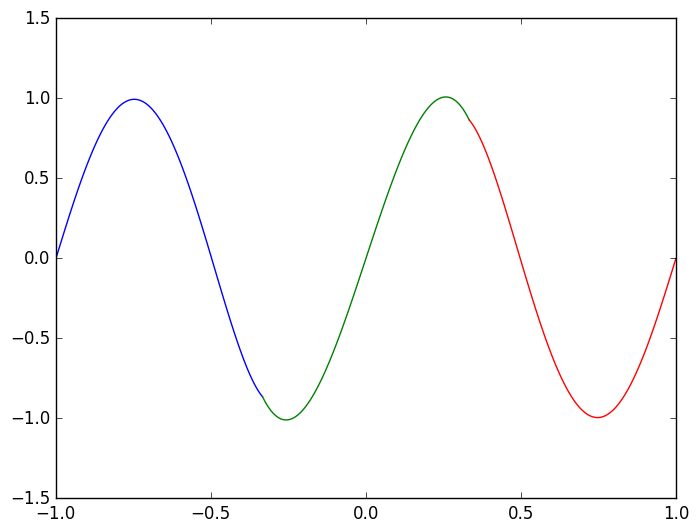

0.03008592224750095

In [49]:
using PyPlot
x = [(1-ξ)*el.a/2 + (1+ξ)*el.b/2 for el in elems]
maxerr = 0.0

for e = 1:nel
    uu = resp(x[e])
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
    plot(x[e], Ue[:,e])
    #plot(x[e], uu, "b")
end
maxerr